In [2]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scipy
#from shap_help import subsample_data, plot_shap_loss, plot_shap_loss_compare
# print the JS visualization code to the notebook
shap.initjs()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# add the helper functions for this example
import sys
sys.path.insert(0, "./helper_functions/")

In [5]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [6]:
print(X.columns.tolist())

['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']


In [7]:
print(X.shape)

print("imbalance ratio: entire dataset")
print(y.sum()/len(y))

print("imbalance ratio: training dataset")
print(y_train.sum()/len(y_train))

print("imbalance ratio: test dataset")
print(y_test.sum()/len(y_test))

(32561, 12)
imbalance ratio: entire dataset
0.2408095574460244
imbalance ratio: training dataset
0.24070945945945946
imbalance ratio: test dataset
0.24120988791647474


In [8]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54808
[100]	test-logloss:0.36173
[200]	test-logloss:0.31471
[300]	test-logloss:0.29647
[400]	test-logloss:0.28744
[500]	test-logloss:0.28226
[600]	test-logloss:0.27921
[700]	test-logloss:0.27754
[800]	test-logloss:0.27661
[869]	test-logloss:0.27622


In [9]:
X_train.iloc[:5]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
5514,33.0,2,13.0,4,10,0,4,0,0.0,0.0,50.0,39
19777,36.0,4,11.0,2,4,4,4,1,0.0,1887.0,50.0,39
10781,58.0,6,5.0,5,3,0,4,1,0.0,0.0,40.0,39
32240,21.0,4,11.0,2,5,4,4,1,0.0,0.0,46.0,39
9876,27.0,4,10.0,0,8,0,4,1,0.0,0.0,40.0,39


In [10]:
# subsample to provide the background data (stratified by the target variable)

X_subsample =X_train.iloc[:50]
y_subsample=y[:50]

In [44]:
explainer_bg_100 = shap.TreeExplainer(model, X_subsample, 
                                      feature_perturbation="interventional", 
                                      model_output="log_loss")

shap_values_logloss_all = explainer_bg_100.shap_values(X,y)

100%|===================| 32506/32561 [07:23<00:00]        

In [45]:
pd.DataFrame(shap_values_logloss_all, columns=X.columns).to_pickle("shap_logloss_total_bg_100.pkl")

In [48]:
model_loss = -np.log(model.predict(xgboost.DMatrix(X)))*y \
                + -np.log(1-model.predict(xgboost.DMatrix(X)))*(1-y)

In [49]:
model_loss[:10]

array([0.01517819, 0.45902938, 0.02189068, 0.10402516, 0.60973465,
       1.70814908, 0.0089539 , 0.94456798, 0.00928112, 0.02689375])

In [50]:
explainer_bg_100.shap_values(X.iloc[:10,:], y[:10]).sum(1) + \
    np.array([explainer_bg_100.expected_value(v) for v in y[:10]])

array([0.01517818, 0.45902905, 0.02189062, 0.10402519, 0.6097348 ,
       1.7081495 , 0.00895389, 0.94456763, 0.00928109, 0.02689372])

In [51]:
print(explainer_bg_100.expected_value(True))

print(explainer_bg_100.expected_value(False))

2.8451931589897557
0.6121452213020835


In [52]:
# the calculation of expected values is based on the background data

X_subsample_index = X_subsample.index
y_subsample = y[X_subsample_index]

In [53]:
### conditional on label

# for instance with True label
y_temp = np.array([True]*len(y_subsample)) # switch all the label to True

model_loss_condition_true = -np.log(model.predict(xgboost.DMatrix(X_subsample)))*y_temp \
                                + -np.log(1-model.predict(xgboost.DMatrix(X_subsample)))*(1-y_temp)

# for instance with False label
y_temp = np.array([False]*len(y_subsample)) # switch all the label to False

model_loss_condition_false = -np.log(model.predict(xgboost.DMatrix(X_subsample)))*y_temp \
                                + -np.log(1-model.predict(xgboost.DMatrix(X_subsample)))*(1-y_temp)

                                          
print(len(model_loss_condition_true))
print(len(model_loss_condition_false))

print("Expected model logloss (based on 100 samples), condition on True: ", model_loss_condition_true.mean())
print("Expected model logloss (based on 100 samples), condition on False: ", model_loss_condition_false.mean())

50
50
Expected model logloss (based on 100 samples), condition on True:  2.8451932922098786
Expected model logloss (based on 100 samples), condition on False:  0.6121452169981785


In [54]:
# model prediction: probability/score of being True
y_predict = model.predict(xgboost.DMatrix(X_subsample))

In [55]:
y_subsample[i]

False

In [59]:
i = 0
print("data label:", y[i])
print("model prediction:", y_predict[i])
print("log loss: ", model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X.iloc[i,:])

data label: False
model prediction: 0.16929089
log loss:  0.015178192406892776


In [60]:
i = 8
print("data label:", y[i])
print("model prediction:", y_predict[i])
print("log loss: ", model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X.iloc[i,:])

data label: True
model prediction: 0.0021131418
log loss:  0.009281119331717491


In [61]:
i = 5
print(y[i])
print(y_predict[i])
print(model_loss[i])

shap.force_plot(explainer_bg_100.expected_value(y[i]), shap_values_logloss_all[i], X.iloc[i,:])

False
0.25219285
1.7081490755081177


In [75]:
for X.columns

'Age'

SHAP loss value plot



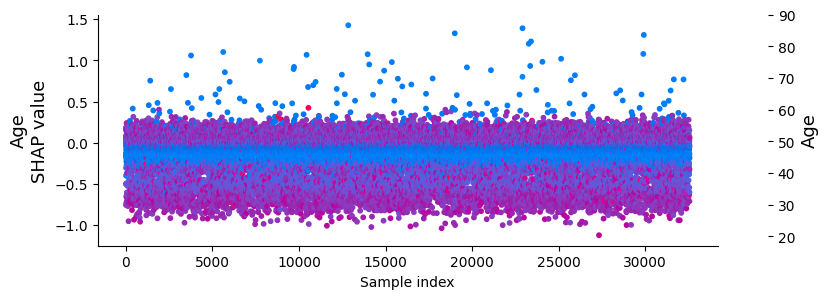

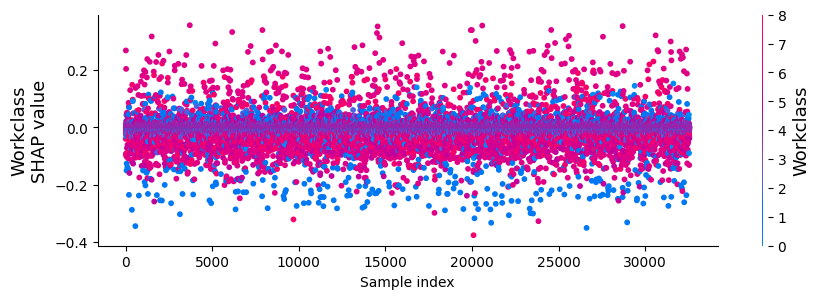

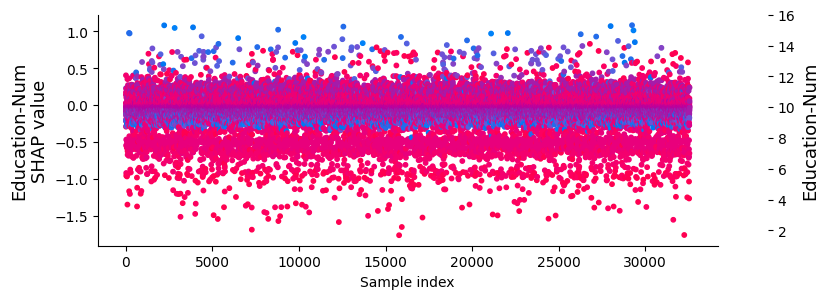

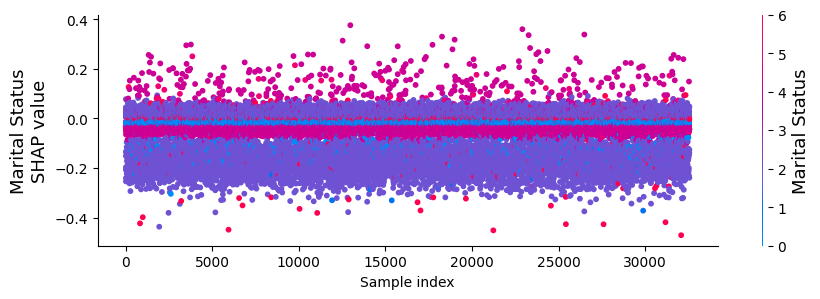

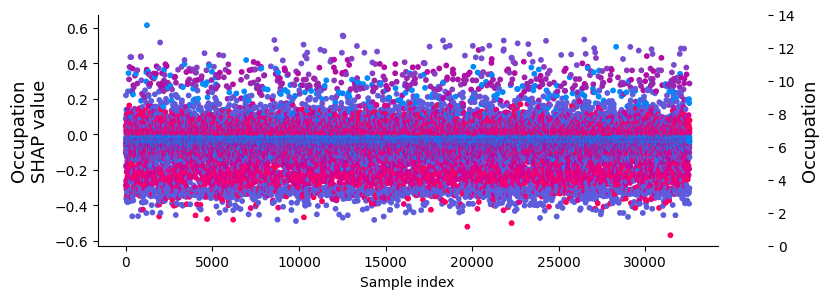

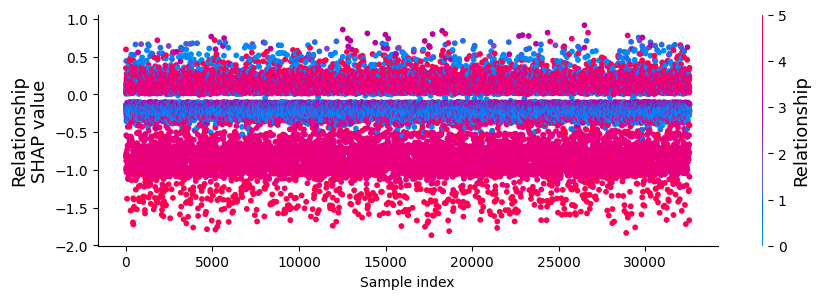

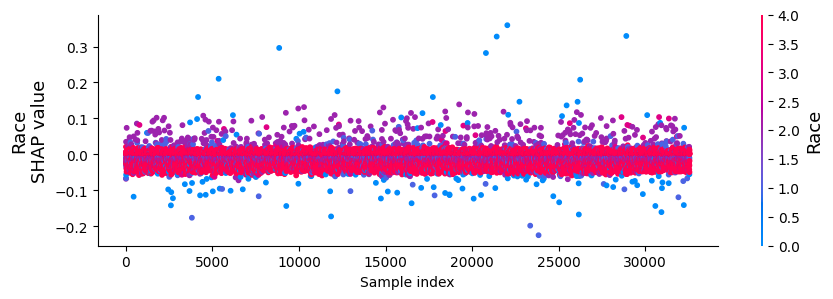

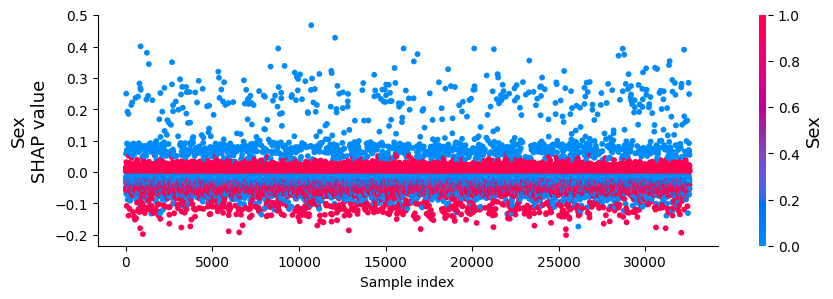

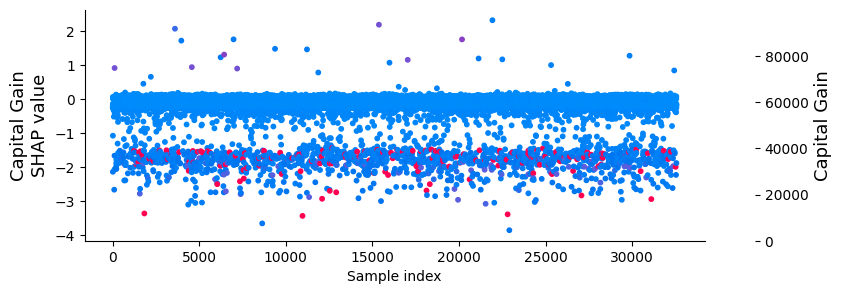

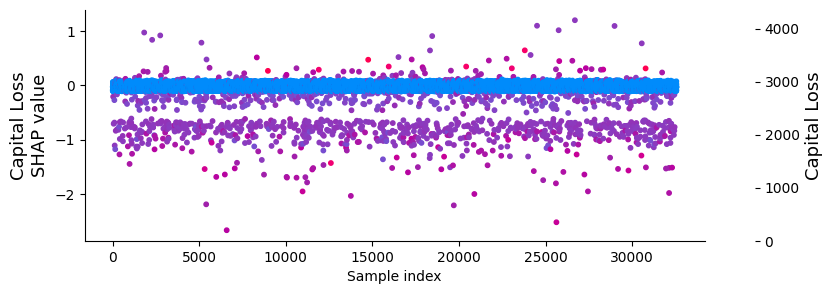

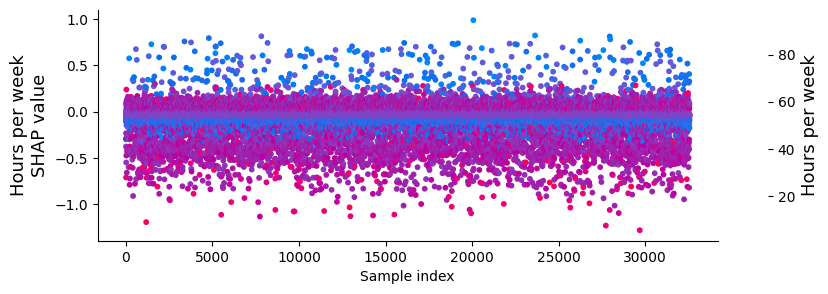

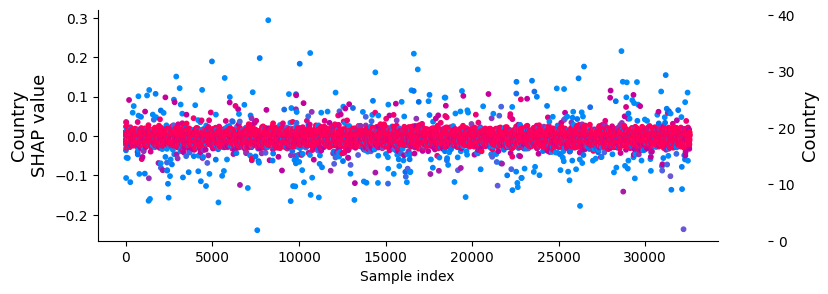

In [76]:
top_features = ["Relationship", "Age", "Education-Num", "Capital Gain"]
print("SHAP loss value plot\n")

for i  in range(len(X.columns)):
    shap.monitoring_plot(i,shap_values_logloss_all, X)